In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [ ]:
!pip install pot


In [ ]:
import os
os.chdir("/kaggle/input")
os.listdir()


['realness-dataset', 'joint_checkpoint', 'raise-final-dataset-paper', 'joint']

In [ ]:
import sys
sys.path.insert(1, '/kaggle/input/joint/pytorch/default/1/')
import JOINT
import random; import numpy as np; import torch
SEED = 78
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [ ]:
class ImageRatingDataset(Dataset):
    
    def __init__(self, dataframe, transform=None, augment=False, phase=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])
        self.augment = augment
        self.phase=phase

        # Define augmentations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        rating = self.dataframe.loc[idx, 'MOS']
        
        if self.phase == 'train':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/train_images/" + img_path).convert('RGB')
        elif self.phase == 'test':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/test_images/" + img_path).convert('RGB')

        if self.augment == True:
            image = self.augmentation(image)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


In [ ]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        self.model = JOINT.JOINT_Model()
        self.model.load_state_dict(torch.load('/kaggle/input/joint_checkpoint/pytorch/default/1/JOINT_2024.pth'))
      

        # # Remove the final classification layer
        # self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        self.features = nn.Sequential(*list(self.model.rationality_feature_extraction.children()))[:-1]


        for layer in self.features[:-2]:
            for param in layer.parameters():
                param.requires_grad = False
            layer.eval()  
        
        # Unfreeze last 2 blocks (keep in train mode)
        for param in self.features[-2:].parameters():
            param.requires_grad = True

     
        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)  # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        x = x.view(x.size(0), -1)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetRegressor().to(device)


/tmp/ipykernel_31/1179402752.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('/kaggle/input/joint_checkpoint/pytorch/default/1/JOIN

In [ ]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 47,547,237


In [ ]:
test_df = pd.read_csv("/kaggle/input/raise-final-dataset-paper/dataset/ratings/test.csv")
print(test_df.shape)


In [ ]:
test_dataset = ImageRatingDataset(test_df, phase='test')
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
checkpoint_path = "/kaggle/working/resnet50_joint-weights.pth"    # your .pth file
state_dict = torch.load(checkpoint_path)  # or "cuda:0"
model.load_state_dict(state_dict)


/tmp/ipykernel_31/93003228.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)  # or "cuda:0"


<All keys matched successfully>

In [ ]:
model.eval()
# model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.7033378606412314 0.7626243


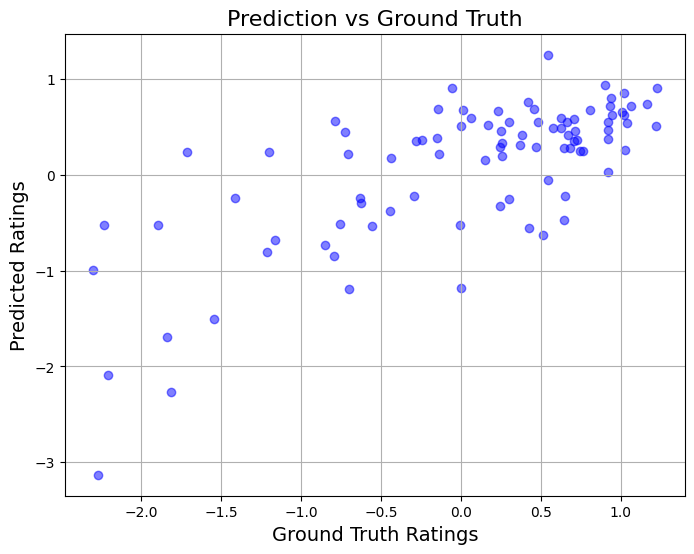

0.6386714409186319 0.72399336


In [ ]:
predictions = []
ground_truths = []
# Iterate over the validation dataset
with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  # Move to device (GPU or CPU)
        ratings = ratings.to(device)

        # Get predictions from the model
        predicted_ratings = model(images)

        # Append predicted and ground truth values to the lists
        predictions.extend(predicted_ratings.cpu().numpy())  # move to CPU and convert to numpy
        ground_truths.extend(ratings.cpu().numpy())  # move to CPU and convert to numpy

# Convert lists to numpy arrays
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()


# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)
